# Subword Embeddings IMDB Reviews

In [1]:
%load_ext autoreload
%autoreload 2

## Install `tfutils`

In [3]:
!pip install -e /content/drive/MyDrive/projects/tfutils

Obtaining file:///content/drive/MyDrive/projects/tfutils
  Running setup.py develop for tfutils


## Some imports

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, optimizers, callbacks
from tfutils.visualize import plot_learning_curve
from tfutils.evaluate import ClassificationPerformanceComparer

## Check GPU

In [3]:
!nvidia-smi

Sat Jul 24 10:49:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load Data

In [4]:
import tensorflow_datasets as tfds
imdb, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)

train_data, test_data = imdb['train'], imdb['test']

print('train:', train_data)
print('test:', test_data)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete7QQLCI/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete7QQLCI/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete7QQLCI/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.
train: <PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>
test: <PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>


In [84]:
CLASS_NAMES = info.features['label'].names

In [5]:
len(train_data), len(test_data)

(25000, 25000)

In [6]:
tokenizer = info.features['text'].encoder

In [7]:
print(tokenizer.subwords)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

In [8]:
sample_string = 'tensorflow, from basics to mastery'
tokenized_string = tokenizer.encode(sample_string)
print('Tokenized string is {}'.format(tokenized_string))

orig_string = tokenizer.decode(tokenized_string)
print('Original string is {}'.format(orig_string))

Tokenized string is [943, 2327, 2934, 2, 48, 4249, 4429, 7, 2652, 8050]
Original string is tensorflow, from basics to mastery


In [9]:
for ts in tokenized_string:
    print(f'{ts} ----> {tokenizer.decode([ts])}')

943 ----> ten
2327 ----> sor
2934 ----> flow
2 ----> , 
48 ----> from 
4249 ----> basi
4429 ----> cs 
7 ----> to 
2652 ----> master
8050 ----> y


* Because the subwords don't make much sense on their own, hence they are highly dependent on the nearby context, hence sequence models will almost always outperform non-sequence models here.

## Global Variables

### What does `padded_batch` do?

In [10]:
A = (tf.data.Dataset
.range(1, 5, output_type=tf.int32)
.map(lambda x: tf.fill([x], x)))

In [11]:
B = A.padded_batch(2)

In [12]:
for e in A.as_numpy_iterator():
    print(e)

for e in B.as_numpy_iterator():
    print(e)

[1]
[2 2]
[3 3 3]
[4 4 4 4]
[[1 0]
 [2 2]]
[[3 3 3 0]
 [4 4 4 4]]


## Preparing the dataset

* Note that the dataset is already prefetched

In [47]:
DATASET_SIZE = len(train_data)
BUFFER_SIZE = 10000 # shuffle last 10k data points
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2
TRAIN_SIZE = int((1 - VALIDATION_SPLIT) * DATASET_SIZE)
VALIDATION_SIZE = int(VALIDATION_SPLIT * DATASET_SIZE)

dataset = train_data.shuffle(BUFFER_SIZE)
train_dataset = dataset.take(TRAIN_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))

validation_dataset = dataset.skip(TRAIN_SIZE)
validation_dataset = validation_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(validation_dataset))

test_dataset = test_data.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_data))

# Create Models

In [52]:
TFMODELS = {}
PREDICTIONS = {}

## Model 1: simple-dense

In [53]:
model_name = 'simple-dense'

In [54]:
model = tf.keras.models.Sequential([
    layers.Embedding(tokenizer.vocab_size, output_dim=64),
    layers.GlobalAveragePooling1D(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name=model_name)

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

model.summary()

Model: "simple-dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 525,953
Trainable params: 525,953
Non-trainable params: 0
_________________________________________________________________


In [56]:
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset,
                    validation_steps=len(validation_dataset))
TFMODELS[model_name] = model

Epoch 1/10
313/313 [==============================] - 11s 32ms/step - loss: 0.6755 - accuracy: 0.6014 - val_loss: 0.6105 - val_accuracy: 0.7888
Epoch 2/10
313/313 [==============================] - 10s 31ms/step - loss: 0.4826 - accuracy: 0.8100 - val_loss: 0.3631 - val_accuracy: 0.8786
Epoch 3/10
313/313 [==============================] - 10s 31ms/step - loss: 0.3280 - accuracy: 0.8814 - val_loss: 0.3237 - val_accuracy: 0.8542
Epoch 4/10
313/313 [==============================] - 10s 31ms/step - loss: 0.2711 - accuracy: 0.8999 - val_loss: 0.2511 - val_accuracy: 0.9112
Epoch 5/10
313/313 [==============================] - 10s 31ms/step - loss: 0.2345 - accuracy: 0.9164 - val_loss: 0.2080 - val_accuracy: 0.9252
Epoch 6/10
313/313 [==============================] - 10s 31ms/step - loss: 0.2155 - accuracy: 0.9211 - val_loss: 0.2028 - val_accuracy: 0.9288
Epoch 7/10
313/313 [==============================] - 10s 30ms/step - loss: 0.1949 - accuracy: 0.9295 - val_loss: 0.2044 - val_accuracy:

### Learning Curve

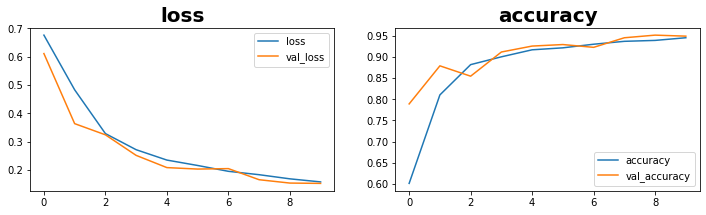

In [57]:
plot_learning_curve(history, extra_metric='accuracy');

### Predictions

In [58]:
PREDICTIONS[model_name] = model.predict(test_dataset)

## Model 2: lstm

In [59]:
model_name = 'lstm'

In [60]:
model = tf.keras.models.Sequential([
    layers.Embedding(tokenizer.vocab_size, output_dim=64),
    layers.LSTM(units=64),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name=model_name)

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

model.summary()

Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 558,977
Trainable params: 558,977
Non-trainable params: 0
_________________________________________________________________


In [61]:
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset,
                    validation_steps=len(validation_dataset))
TFMODELS[model_name] = model

Epoch 1/10
313/313 [==============================] - 31s 92ms/step - loss: 0.6933 - accuracy: 0.5024 - val_loss: 0.6934 - val_accuracy: 0.4992
Epoch 2/10
313/313 [==============================] - 29s 91ms/step - loss: 0.6930 - accuracy: 0.5088 - val_loss: 0.6926 - val_accuracy: 0.5164
Epoch 3/10
313/313 [==============================] - 29s 91ms/step - loss: 0.6920 - accuracy: 0.5006 - val_loss: 0.6913 - val_accuracy: 0.5246
Epoch 4/10
313/313 [==============================] - 29s 90ms/step - loss: 0.6905 - accuracy: 0.5081 - val_loss: 0.6896 - val_accuracy: 0.5054
Epoch 5/10
313/313 [==============================] - 29s 92ms/step - loss: 0.6897 - accuracy: 0.5059 - val_loss: 0.6874 - val_accuracy: 0.5012
Epoch 6/10
313/313 [==============================] - 29s 91ms/step - loss: 0.6873 - accuracy: 0.5068 - val_loss: 0.6874 - val_accuracy: 0.5160
Epoch 7/10
313/313 [==============================] - 29s 91ms/step - loss: 0.6869 - accuracy: 0.5060 - val_loss: 0.6841 - val_accuracy:

### Learning Curve

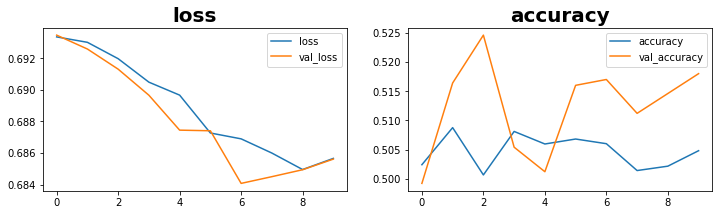

In [62]:
plot_learning_curve(history, extra_metric='accuracy');

### Predictions

In [63]:
PREDICTIONS[model_name] = model.predict(test_dataset)

## Model 3: bi-lstm

In [64]:
model_name = 'bi-lstm'

In [65]:
model = tf.keras.models.Sequential([
    layers.Embedding(tokenizer.vocab_size, output_dim=64),
    layers.Bidirectional(layers.LSTM(units=64)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name=model_name)

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

model.summary()

Model: "bi-lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 594,049
Trainable params: 594,049
Non-trainable params: 0
_________________________________________________________________


In [66]:
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset,
                    validation_steps=len(validation_dataset))
TFMODELS[model_name] = model

Epoch 1/10
313/313 [==============================] - 50s 148ms/step - loss: 0.5349 - accuracy: 0.7223 - val_loss: 0.3619 - val_accuracy: 0.8594
Epoch 2/10
313/313 [==============================] - 48s 150ms/step - loss: 0.3941 - accuracy: 0.8346 - val_loss: 0.4310 - val_accuracy: 0.8000
Epoch 3/10
313/313 [==============================] - 48s 151ms/step - loss: 0.5665 - accuracy: 0.7083 - val_loss: 0.8623 - val_accuracy: 0.5000
Epoch 4/10
313/313 [==============================] - 47s 148ms/step - loss: 0.6180 - accuracy: 0.6678 - val_loss: 0.6404 - val_accuracy: 0.6158
Epoch 5/10
313/313 [==============================] - 47s 149ms/step - loss: 0.5605 - accuracy: 0.7203 - val_loss: 0.4617 - val_accuracy: 0.7922
Epoch 6/10
313/313 [==============================] - 48s 150ms/step - loss: 0.5007 - accuracy: 0.7621 - val_loss: 0.4894 - val_accuracy: 0.8152
Epoch 7/10
313/313 [==============================] - 48s 152ms/step - loss: 0.3692 - accuracy: 0.8426 - val_loss: 0.7685 - val_ac

### Learning Curve

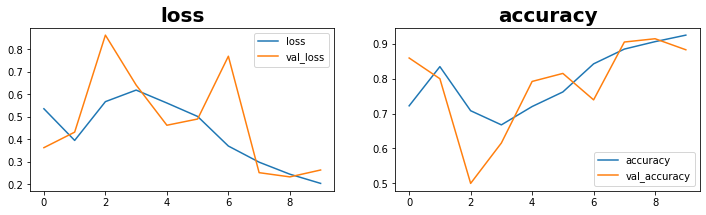

In [67]:
plot_learning_curve(history, extra_metric='accuracy');

### Predictions

In [68]:
PREDICTIONS[model_name] = model.predict(test_dataset)

## Model 4: conv1d

In [69]:
model_name = 'conv1d'

In [70]:
model = tf.keras.models.Sequential([
    layers.Embedding(tokenizer.vocab_size, output_dim=64),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name=model_name)

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

model.summary()

Model: "conv1d"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         41088     
_________________________________________________________________
global_average_pooling1d_3 ( (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 569,089
Trainable params: 569,089
Non-trainable params: 0
_________________________________________________________________


In [71]:
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset,
                    validation_steps=len(validation_dataset))
TFMODELS[model_name] = model

Epoch 1/10
313/313 [==============================] - 33s 61ms/step - loss: 0.4958 - accuracy: 0.7517 - val_loss: 0.3144 - val_accuracy: 0.8776
Epoch 2/10
313/313 [==============================] - 15s 46ms/step - loss: 0.2474 - accuracy: 0.9074 - val_loss: 0.2008 - val_accuracy: 0.9260
Epoch 3/10
313/313 [==============================] - 13s 41ms/step - loss: 0.1928 - accuracy: 0.9291 - val_loss: 0.1543 - val_accuracy: 0.9508
Epoch 4/10
313/313 [==============================] - 13s 39ms/step - loss: 0.1576 - accuracy: 0.9441 - val_loss: 0.1278 - val_accuracy: 0.9586
Epoch 5/10
313/313 [==============================] - 13s 38ms/step - loss: 0.1387 - accuracy: 0.9512 - val_loss: 0.1178 - val_accuracy: 0.9640
Epoch 6/10
313/313 [==============================] - 13s 39ms/step - loss: 0.1162 - accuracy: 0.9607 - val_loss: 0.0890 - val_accuracy: 0.9764
Epoch 7/10
313/313 [==============================] - 13s 38ms/step - loss: 0.1003 - accuracy: 0.9675 - val_loss: 0.0812 - val_accuracy:

### Learning Curve

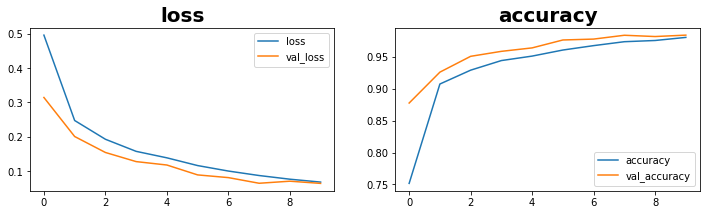

In [72]:
plot_learning_curve(history, extra_metric='accuracy');

### Predictions

In [73]:
PREDICTIONS[model_name] = model.predict(test_dataset)

## Performance Comparison

In [96]:
test_size = (len(test_dataset)*test_dataset._batch_size).numpy()
y_test = list(map(lambda x: x[1], test_dataset))

In [104]:
y_test = tf.concat(y_test, axis=0).numpy()

In [105]:
preds = list(PREDICTIONS.values())
model_names = list(PREDICTIONS.keys())

clf_comp = ClassificationPerformanceComparer.from_predictions(predictions=preds, 
                                                              data=(None, y_test),
                                                              model_names=model_names,
                                                              class_names=CLASS_NAMES)

clf_comp.calculate_metric_comparison_df()

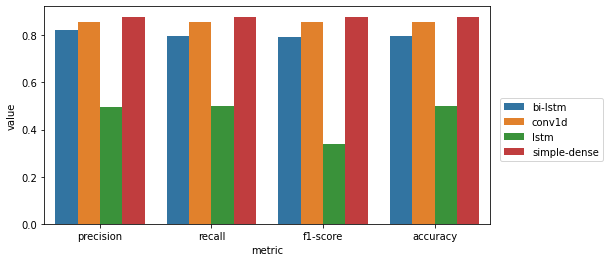

In [106]:
clf_comp.plot_metric_comparison_df()

Extremely surprising!

* The best model is `simple-dense`
* The worst model is LSTM, while adding the bidirectional layer made huge improvements. This could be because subwords require the context to be accompanied on both sides.
* Maybe if we train the conv1d model a bit more, then it could outperform the simple-dense model.

## Prediction Pipeline

In [129]:
NUM_SENTS = 5
sents = [None]*NUM_SENTS
labels = [None]*NUM_SENTS

for i, (seq, lab) in enumerate(test_dataset.unbatch().take(NUM_SENTS)):
    sents[i] = info.features['text'].encoder.decode(seq)
    labels[i] = lab.numpy()

sents = np.array(sents)
labels = np.array(labels)
clsnames = np.array(CLASS_NAMES)[labels]

In [126]:
pred_probs = model.predict(test_dataset.unbatch().take(5).batch(5))
pred_labs = np.squeeze((pred_probs > 0.5).astype(int))
pred_clsnames = np.array(CLASS_NAMES)[pred_labs]


In [142]:
for i in range(NUM_SENTS):
    if pred_labs[i] == 0:
        conf = (1 - pred_probs[i, 0])*100
    else:
        conf = pred_probs[i, 0]*100

    print(f'Actual: {clsnames[i]}, Predicted: {pred_clsnames[i]} (Confidence: {conf:.2f} %)')
    print('-'*10)
    print(sents[i])
    print('\n')

Actual: pos, Predicted: neg (Confidence: 67.74 %)
----------
There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.

## Download Pretrained Subword Embeddings

In [177]:
!mkdir /tmp/bpe_subwords_embed_en
!wget https://bpemb.h-its.org/en/en.wiki.bpe.vs10000.d300.w2v.txt.tar.gz -P /tmp/bpe_subwords_embed_en
!tar -xzf /tmp/bpe_subwords_embed_en/en.wiki.bpe.vs10000.d300.w2v.txt.tar.gz -C /tmp/bpe_subwords_embed_en/

mkdir: cannot create directory ‘/tmp/bpe_subwords_embed_en’: File exists
--2021-07-24 12:56:46--  https://bpemb.h-its.org/en/en.wiki.bpe.vs10000.d300.w2v.txt.tar.gz
Resolving bpemb.h-its.org (bpemb.h-its.org)... 193.197.73.111
Connecting to bpemb.h-its.org (bpemb.h-its.org)|193.197.73.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26701297 (25M) [application/x-gzip]
Saving to: ‘/tmp/bpe_subwords_embed_en/en.wiki.bpe.vs10000.d300.w2v.txt.tar.gz’

en.wiki.bpe.vs10000 100%[===================>]  25.46M  12.0MB/s    in 2.1s    

2021-07-24 12:56:49 (12.0 MB/s) - ‘/tmp/bpe_subwords_embed_en/en.wiki.bpe.vs10000.d300.w2v.txt.tar.gz’ saved [26701297/26701297]



In [178]:
!ls /tmp/bpe_subwords_embed_en/data/en

en.wiki.bpe.vs10000.d300.w2v.bin  en.wiki.bpe.vs10000.d300.w2v.txt


In [179]:
!head /tmp/bpe_subwords_embed_en/data/en/en.wiki.bpe.vs10000.d300.w2v.txt

10000 300
<unk> 0.6418240070343018 0.3353320062160492 0.25327399373054504 0.22111600637435913 1.1262389421463013 0.19315700232982635 -0.7871689796447754 0.08849000185728073 0.07042600214481354 -0.2168309986591339 -0.12212900072336197 0.2985140085220337 0.33378100395202637 -0.0803299993276596 0.1732580065727234 0.16024699807167053 -0.1430239975452423 0.23496399819850922 -0.33278000354766846 -0.09424500167369843 0.11016199737787247 0.07153700292110443 -0.15296000242233276 -0.2669689953327179 0.19896100461483002 0.20851999521255493 0.14161700010299683 0.29962098598480225 -0.49064600467681885 0.04520000144839287 -0.36313700675964355 -0.3204070031642914 -0.15895000100135803 -0.22266800701618195 0.1326970010995865 0.06199999898672104 0.18741600215435028 0.18649399280548096 0.09013199806213379 0.2749750018119812 0.31082698702812195 -0.20338399708271027 0.46074798703193665 0.2938559949398041 -0.0635410025715828 -0.3077470064163208 0.4985780119895935 0.2513140141963959 -0.24984799325466156 0.18

In [175]:
def load_bin_vec(fname):
    word_vecs = {}
    with open(fname, 'rb') as f:
        header = f.readline()
        vocab_size, layer1_size = map(int, header.split())
        binary_len = np.dtype('float32').itemsize*layer1_size

        for line in range(vocab_size):
            word = []
            ch = f.read(1)
            if ch == ' ':
                word = ''.join(word)
                break

            if ch != '\n':
                word.append(ch)

            word_vecs[word] = np.fromstring(f.read(binary_len), dtype='float32')

    return word_vecs

In [215]:
def load_txt_vec(fname, token2id=None):

    parse_all = token2id is None

    with open(fname, 'r') as f:
        header = f.readline()
        vocab_size, embed_dim = list(map(int, header.split(' ')))

        if not parse_all:
            vocab_size = len(token2id)
        else:
            token2id = {}
        
        embed_mat = np.zeros(shape=(vocab_size, embed_dim))

        if parse_all:
            for i, line in enumerate(f.readlines()):
                splt_line = line.split(' ')
                token = splt_line[0]
                vecs = np.array(splt_line[1:], dtype=np.float32)
                embed_mat[i] = vecs
                token2id[token] = i

        else:
            for line in f.readlines():
                splt_line = line.split(' ')
                token = splt_line[0]
                if token in token2id:
                    vecs = np.array(splt_line[1:], dtype=np.float32)
                    i = token2id[token]
                    embed_mat[i] = vecs
                
    return token2id, embed_mat


In [216]:
token2id = {token: idx for idx, token in enumerate(tokenizer.subwords)}

In [217]:
token2id, embed_mat = load_txt_vec('/tmp/bpe_subwords_embed_en/data/en/en.wiki.bpe.vs10000.d300.w2v.txt', token2id) 

In [225]:
(embed_mat == 0).all(axis=1).mean()

0.8380423814328961